In [13]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import sys
sys.path.append("/home/javi/Documents/brainhack-physio-project/code")
from input import get_ecg_data, get_info_data
from events import compute_max_events
from clean import butter_bandpass_filter
from scipy.signal import welch

In [3]:
%%time
info,initial_time,final_time,n_vols,n_slices,rep_time = get_info_data('../data/sample1/Physio_sample1_Info.log', range(4))

CPU times: user 79.9 ms, sys: 7.51 ms, total: 87.4 ms
Wall time: 89.7 ms


In [6]:
%%time
ecg_1,_,_ = get_ecg_data("../data/sample1/Physio_sample1_ECG.log", initial_time, final_time)

CPU times: user 1.67 s, sys: 47.5 ms, total: 1.72 s
Wall time: 1.71 s


In [10]:
signal = ecg_1[:,1]- ecg_1[:,-1]
signal_filt = butter_bandpass_filter(signal, lowcut=0.75, highcut=2.0, fs=400)

In [10]:
ecg_1 = ecg_1[0]

In [11]:
ecg_1_filtered = butter_bandpass_filter(ecg_1[:,1], lowcut=0.75, highcut=2.0, fs=400)
ecg_2_filtered = butter_bandpass_filter(ecg_1[:,2], lowcut=0.75, highcut=2.0, fs=400)
ecg_3_filtered = butter_bandpass_filter(ecg_1[:,3], lowcut=0.75, highcut=2.0, fs=400)
ecg_4_filtered = butter_bandpass_filter(ecg_1[:,4], lowcut=0.75, highcut=2.0, fs=400)

In [67]:
from scipy.signal import butter
# bandpass signal

?butter

(5000.0, 10000.0)

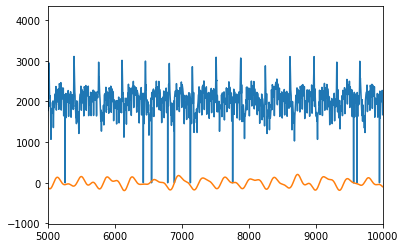

In [12]:
plt.plot(ecg_1[:,1])
plt.plot(ecg_1_filtered)
plt.xlim([5000, 10000])

(-300.0, 300.0)

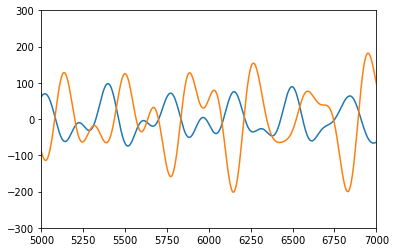

In [13]:
plt.plot(ecg_2_filtered-ecg_1_filtered)
plt.xlim([5000, 7000])

plt.plot(ecg_2_filtered-ecg_4_filtered)
plt.xlim([5000, 7000])
plt.ylim([-300, 300])

(-300.0, 300.0)

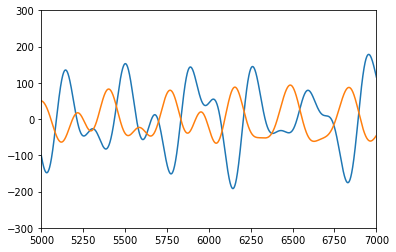

In [124]:
plt.plot(ecg_1_filtered)
plt.xlim([5000, 7000])

plt.plot(ecg_4_filtered)
plt.xlim([5000, 7000])
plt.ylim([-300, 300])

In [121]:
#compute_max_events(ecg_1_filtered, peak_rise=200, delta=0.75)

In [15]:
from scipy.signal import find_peaks, find_peaks_cwt
from events import compute_max_events

In [35]:
signal = ecg_4_filtered-ecg_1_filtered

print(len(find_peaks(signal, distance=200, width=400, rel_height=0.75)[0]))
print(len(compute_max_events(signal, peak_rise=0.75, delta=200)))

9
598


In [30]:
find_peaks?

NameError: name 'find_peaks' is not defined

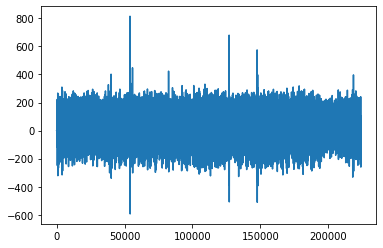

In [14]:
plt.plot(signal)
plt.scatter(find_peaks(signal, distance=200)[0], 
            signal[find_peaks(signal, distance=200)[0]], c="red")
plt.xlim([5000, 7000])

In [185]:
# Compute average difference between peaks
signal = np.mean([ecg_2_filtered, ecg_1_filtered], axis=0)
np.median(np.diff(find_peaks(signal,  distance=200, threshold=0.75)[0]))/400*60

/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/javi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [180]:
ecg_duration = (ecg_1[:,0][-1]-ecg_1[:,0][0])/400
n_peaks = len(find_peaks(ecg_1_filtered, distance=200)[0])
heart_rate = n_peaks/(ecg_duration/60)
heart_rate

66.82134570765662

In [133]:
560.3/60

9.338333333333333

In [38]:
from scipy.misc import electrocardiogram
foo = electrocardiogram()

In [43]:
find_peaks(foo)[0].shape

(14778,)

In [27]:
5000/400

12.5

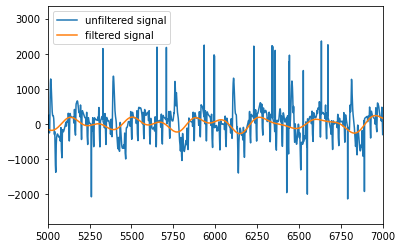

In [37]:
peaks = compute_max_events(signal_filt, peak_rise=0.75, delta=200)



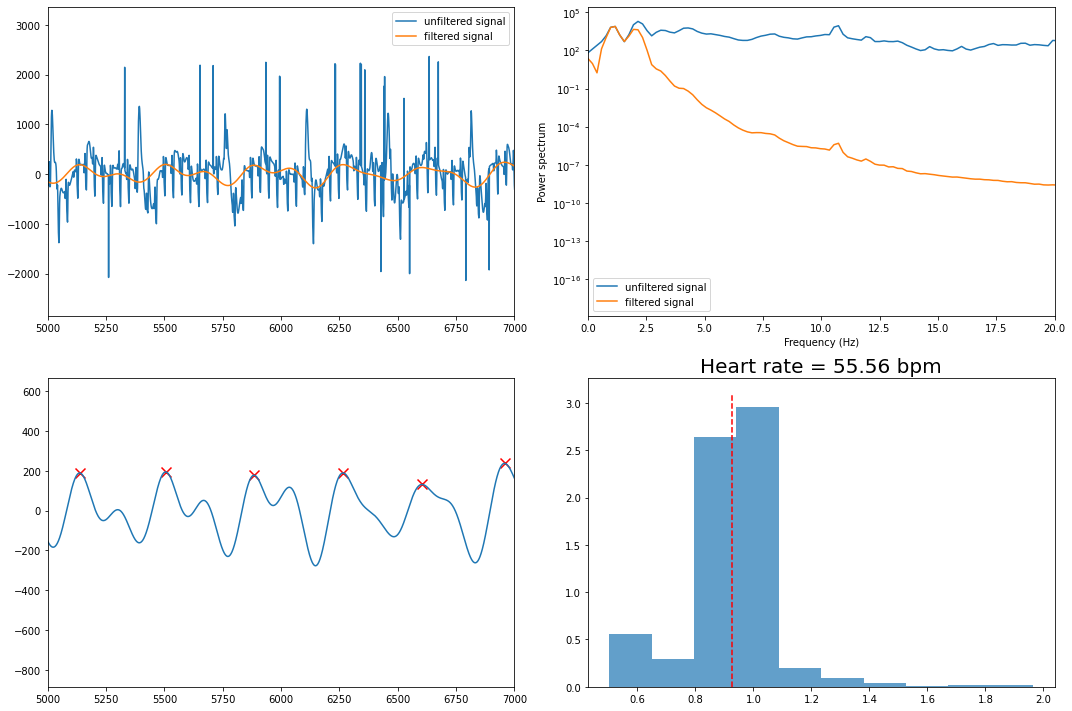

In [65]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
# Plot signal for 5 seconds signal
ax = axs[0,0]
ax.plot(signal, label="unfiltered signal")
ax.plot(signal_filt, label="filtered signal")
ax.set_xlim([5000, 7000])
ax.legend()

# Show how frequencies are filtered 
ax = axs[0,1]
f, Pxx = welch(signal, fs=400, nperseg=2048, scaling="spectrum")
ax.semilogy(f, Pxx, label="unfiltered signal")
f, Pxx = welch(signal_filt, fs=400, nperseg=2048, scaling="spectrum")
ax.semilogy(f, Pxx, label="filtered signal")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power spectrum")
ax.set_xlim([0,20])
ax.legend()

# Compute peaks and plot a portion of data (5 secs)
ax = axs[1,0]
peaks = compute_max_events(signal_filt, peak_rise=0.75, delta=200)

ax.plot(signal_filt)
ax.scatter(peaks.astype(int), signal_filt[peaks.astype(int)], c="red", marker="x", s=100)
ax.set_xlim([5000, 7000])

# Compute signal around peaks
sign_peaks = []
delta = 200
for pk in peaks.astype(int):
    i_0 = pk-delta
    i_f = pk+delta
    if i_0 < 0:
        continue
    if i_f > len(signal_filt):
        continue
    sign_peaks.append(signal_filt[i_0:i_f])

diff_peaks = abs(np.diff(peaks))
heart_rate = np.mean(diff_peaks/400)*60
ax = axs[1,1]
ax.hist(diff_peaks/400, density=True, alpha=0.7)
ax.vlines(np.mean(diff_peaks/400), ymin=0, ymax=ax.get_ylim()[1], color="red", linestyles="--")
ax.set_title("Heart rate = %.2f bpm" % heart_rate, size=20)
plt.tight_layout()

<ErrorbarContainer object of 3 artists>

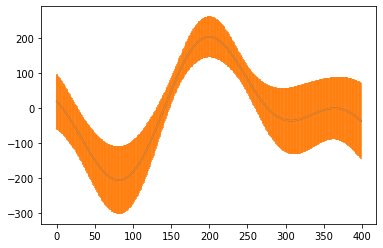

In [97]:
plt.plot(np.mean(np.array(foo), axis=0))
plt.errorbar(x=np.arange(400),
             y = np.mean(np.array(foo), axis=0),
             yerr = np.std(np.array(foo), axis=0),
            )

In [94]:
plt.errorbar?